In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook

# Real World Considerations for the Lomb-Scargle Periodogram

**Version 0.2**

* * *

By AA Miller (Northwestern/CIERA)  
23 Sep 2021

In [Lecture III](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/main/Session13/Day3/IntroductionToTheLombScarglePeriodogram.ipynb) we built the software necessary to estimate the power spectrum via the Lomb-Scargle periodogram. 

We also discovered that LS is somewhat slow. We will now leverage the faster implementation in `astropy`, while exploring some specific challenges related to real astrophysical light curves.

The helper functions from [Lecture III](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/main/Session13/Day3/IntroductionToTheLombScarglePeriodogram.ipynb) are recreated at the end of this notebook - execute those cells and then the cell below to recreate the simulated data from Lecture III.

In [78]:
np.random.seed(185)
# calculate the periodogram

x = 10*np.random.rand(100)
y = gen_periodic_data(x, period=5.25, amplitude=7.4, noise=0.8)
y_unc = np.ones_like(x)*np.sqrt(0.8)

## Problem 1) Other Considerations and Faster Implementations

While our "home-grown" `ls_periodogram` works, it would take a loooooong time to evaluate $\sim4\times 10^5$ frequencies for $\sim2\times 10^7$ variable LSST sources. (as is often the case...) `astropy` to the rescue!

**Problem 1a**

[`LombScargle`](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) in `astropy.timeseries` is fast. Run it below to compare to `ls_periodogram`.

In [79]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(x, y, y_unc).autopower()

Unlike `ls_periodogram`, `LombScargle` effectively takes no time to run on the simulated data. 

**Problem 1b**

Plot the periodogram for the simulated data.

<IPython.core.display.Javascript object>


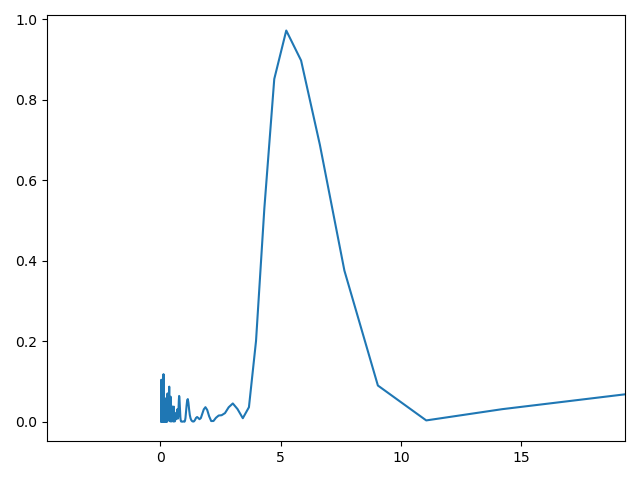

In [80]:
fig, ax = plt.subplots()

ax.plot( 1/frequency, power)

fig.tight_layout()

There are many choices regarding the calculation of the periodogram, so [read the docs](http://docs.astropy.org/en/stable/api/astropy.stats.LombScargle.html#astropy.stats.LombScargle).

### Floating Mean Periodogram

A basic assumption that we preivously made is that the data are "centered" - in other words, our model explicitly assumes that the signal oscillates about a mean of 0.

For astronomical applications, this assumption can be harmful. Instead, it is useful to fit for the mean of the signal in addition to the periodic component (as is the default in `LombScargle`):

$$y(t;f) = y_0(f) + A_f \sin(2\pi f(t - \phi_f).$$

To illustrate why this is important for astronomy, assume that any signal fainter than $-2$ in our simulated data cannot be detected. 

**Problem 1c**

Remove the observations from `x` and `y` where $y \le -2$ and calculate the periodogram both with and without fitting the mean (`fit_mean = False` in the call to `LombScargle`). Plot the periodograms. Do both methods recover the correct period? 

<IPython.core.display.Javascript object>


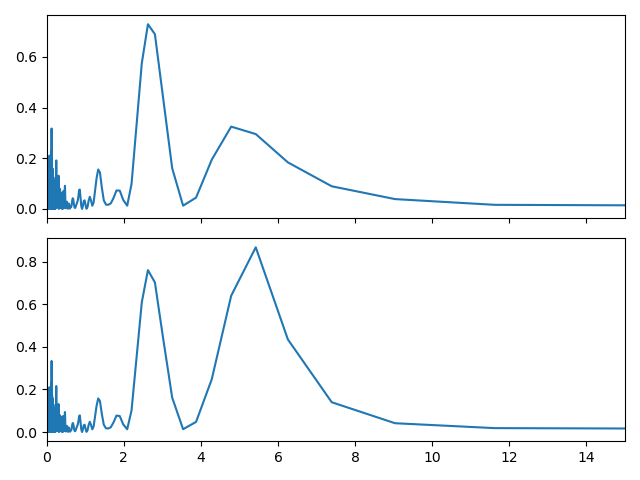

In [81]:
bright=y>-2
freq_no_mean, power_no_mean = LombScargle( x[bright], y[bright], y_unc[bright], fit_mean = False).autopower()
freq_fit_mean, power_fit_mean = LombScargle( x[bright], y[bright], y_unc[bright], fit_mean = True).autopower()
    
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot( 1/freq_no_mean, power_no_mean)
ax2.plot( 1/freq_fit_mean, power_fit_mean)
ax1.set_xlim(0,15)

fig.tight_layout()

We can see that the best fit model doesn't match the signal in the case where we do not allow a floating mean.

<IPython.core.display.Javascript object>


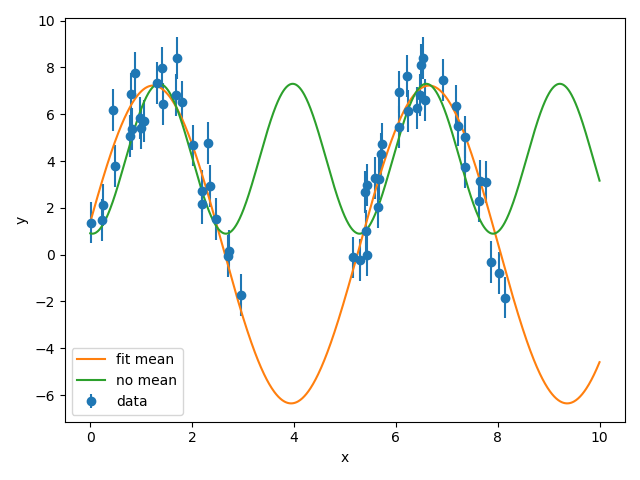

In [82]:
fit_mean_model = LombScargle(x[bright], y[bright], y_unc[bright], 
                             fit_mean=True).model(np.linspace(0,10,1000),
                                                  freq_fit_mean[np.argmax(power_fit_mean)])
no_mean_model = LombScargle(x[bright], y[bright], y_unc[bright], 
                             fit_mean=False).model(np.linspace(0,10,1000),
                                                  freq_no_mean[np.argmax(power_no_mean)])

fig, ax = plt.subplots()
ax.errorbar(x[bright], y[bright], y_unc[bright], fmt='o', label='data')
ax.plot(np.linspace(0,10,1000), fit_mean_model, label='fit mean')
ax.plot(np.linspace(0,10,1000), no_mean_model, label='no mean')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
fig.tight_layout()

### Window Functions

Recall that the convolution theorem tells us that:

$$\mathcal{F}[f\cdot g] = \mathcal{F}(f) \ast \mathcal{F}(g)$$

Telescope observations are effectively the product of a continous signal with several delta functions (corresponding to the times of observations). As a result, the convolution that produces the periodogram will retain signal from both the source and the observational cadence.

To illustrate this effect, let us simulate "realistic" observations for a 10 year telescope survey. We do this by assuming that a source is observed every 3 nights (the LSST cadence) within $\pm 4\,\mathrm{hr}$ of the same time, and that $\sim 30\%$ of the observations did not occur due to bad weather. We further assume that the source cannot be observed for 40% of the year because it is behind the sun.

Simulate a periodic signal with this cadence, a period = 220 days (typical for Miras), amplitude = 12.4, and noise = 1. Plot the simulated light curve.

**Problem 1d**

Simulate a periodic signal with 3 day cadence (and the observing conditions described above), a period = 220 days (typical for Miras), amplitude = 12.4, and variance of the noise = 1. Plot the simulated light curve.

521


<IPython.core.display.Javascript object>


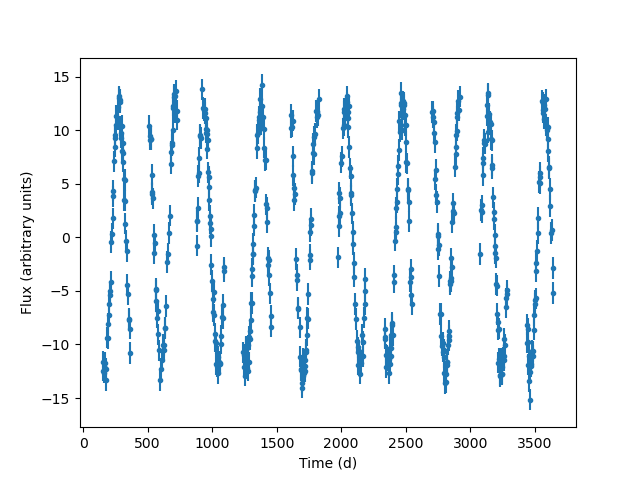

Text(0, 0.5, 'Flux (arbitrary units)')

In [87]:
# set up simulated observations
t_obs = np.arange(0, 10*365, 3)      # 3d cadence

t_obs = t_obs + (np.random.rand(3650//3+1)-0.5)*4/24
t_obs = np.delete(t_obs, (t_obs%365 < 0.4*365))
t_obs = t_obs[np.random.choice([True,False], size=len(t_obs), p=[0.7,0.3])]
# Adam's alternative: t_obs = t_obs[np.random.rand(len(t_obs)) <= 0.7]
print(len(t_obs))



y = gen_periodic_data(t_obs,220,12.4,0,1)
y_unc = np.ones_like(t_obs)*np.sqrt(1)

fig, ax = plt.subplots()
ax.errorbar(t_obs, y, y_unc, fmt='.')
ax.set_xlabel("Time (d)")

ax.set_ylabel("Flux (arbitrary units)")

**Problem 1e MH: Check answers, mine are very different to Adam's**

Calculate and plot the periodogram for the window function (i.e., set `y = 1` in `LombScargle`) of the observations. Do you notice any significant power? 

*Hint* - you may need to zoom in on the plot to see all the relevant features.

MH: next cell sometimes gives dividebyzero error, rereun data generation to fix, unsure why

[2.86116087e-05 8.58348260e-05 1.43058043e-04 2.00281261e-04
 2.57504478e-04]


<IPython.core.display.Javascript object>


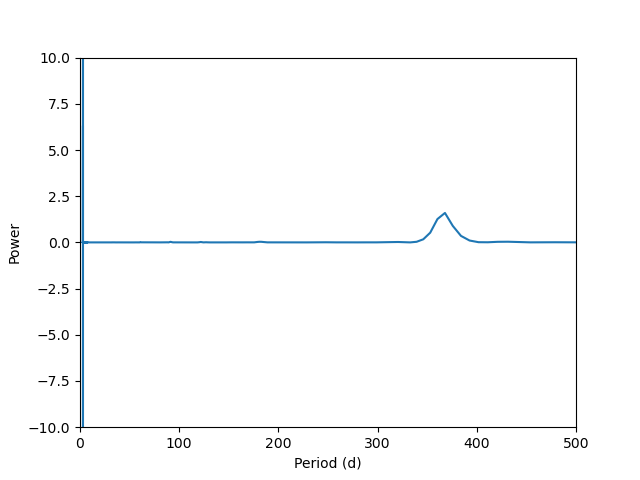

<IPython.core.display.Javascript object>


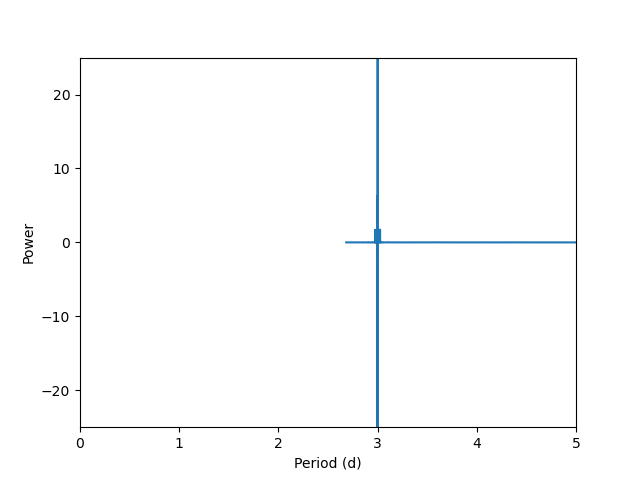

(-25.0, 25.0)

In [88]:
ls = LombScargle( t_obs, np.ones_like(t_obs))
    
freq_window, power_window = ls.autopower()
print(freq_window[:5])

fig, ax = plt.subplots()
ax.plot( 1/freq_window, power_window)
ax.set_ylabel("Power")
ax.set_xlabel("Period (d)")
ax.set_xlim(0,500)
ax.set_ylim(-10,10)

#axins = plt.axes([.2, .65, .5, .2])
#axins.plot( 1/freq_window, power_window)
#axins.set_xlim(0,5)
fig, ax = plt.subplots()
ax.plot( 1/freq_window, power_window)
ax.set_ylabel("Power")
ax.set_xlabel("Period (d)")
ax.set_xlim(0,5)
ax.set_ylim(-25,25)

#print(power_window[np.argsort(power_window)][-10:-1])
#print(1/freq_window[np.argsort(power_window)][-10:-1])

Interestingly, there are very strong peaks in the data at $P \approx 3\,\mathrm{d} \;\&\; 365\,\mathrm{d}$. 

What is this telling us? Essentially that observations are likely to be repeated at intervals of 3 or 365 days (shorter period spikes are aliases of the 3 d peak).

This is important to understand, however, because this same power will be present in the periodogram where we search for the periodic signal.

**Problem 1f**

Calculate the periodogram for the data and compare it to the periodogram for the window function. 

<IPython.core.display.Javascript object>


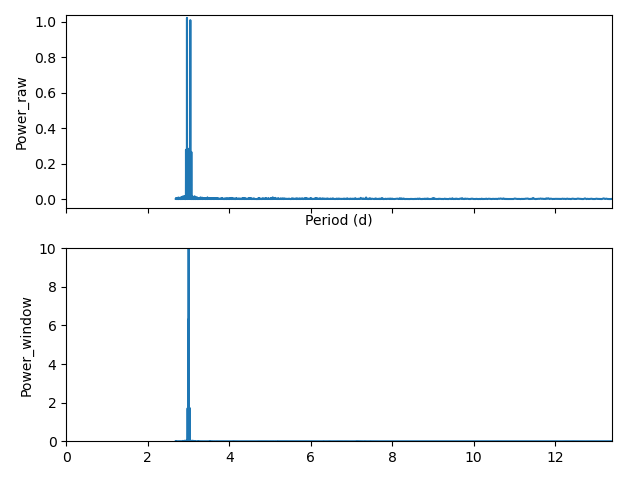

6513 6513
0


In [89]:
ls = LombScargle( t_obs,y,y_unc)

frequency, power = ls.autopower()

fig, (ax,ax2) = plt.subplots(2,1, sharex=True)
ax.plot(1/frequency,power)
ax.set_ylabel("Power_raw")
ax.set_xlabel("Period (d)")
ax.set_xlim(0,500)
#ax.set_ylim(0,1)

ax2.plot(1/freq_window,power_window)
ax2.set_ylabel("Power_window")
ax2.set_ylim(0,10)
fig.tight_layout()

print(len(freq_window),len(frequency))
print(np.count_nonzero(freq_window-frequency)) # checking freq_window and frequency are equal - should be




### Uncertainty on the best-fit period

How do we report uncertainties on the best-fit period from LS? For example, for the previously simulated LSST light curve we would want to report something like $P = 102 \pm 4\,\mathrm{d}$. However, the uncertainty from LS periodograms cannot be determined in this way. 

Naively, one could report the width of the peak in the periodogram as the uncertainty in the fit. However, we previously saw that the peak width $\propto 1/T$ (the peak width does not decrease as the number of observations or their S/N increases; see Vander Plas 2017). Reporting such an uncertainty is particularly ridiculous for long duration surveys, whereby the peaks become very very narrow.

An alternative approach is to report the False Alarm Probability (FAP), which estimates the probability that a dataset with no periodic signal could produce a peak of similar magnitude, due to random gaussian fluctuations, as the data. 

There are a few different methods to calculate the FAP. Perhaps the most useful, however, is the bootstrap method. To obtain a bootstrap estimate of the LS FAP one leaves the observation times fixed, and then draws new observation values with replacement from the actual set of observations. This procedure is then repeated many times to determine the FAP. 

One nice advantage of this procedure is that any effects due to the window function will be imprinted in each iteration of the bootstrap resampling. 

The major disadvantage is that many many periodograms must be calculated. The rule of thumb is that to acieve a FAP $= p_\mathrm{false}$, one must run $n_\mathrm{boot} \approx 10/p_\mathrm{false}$ bootstrap periodogram calculations. Thus, an FAP $\approx 0.1\%$ requires an increase of 1000 in computational time. 

`LombScargle` provides the [`false_alarm_probability`](One nice advantage of this procedure is that any effects due to the window function will be imprinted in each iteration of the bootstrap resampling. The major disadvantage is that many many periodograms must be calculated) method, including a bootstrap option. We skip that for now in the interest of time.

As a final note of caution - be weary of over-interpreting the FAP. The specific question answered by the FAP is, what is the probability that gaussian fluctations could produce a signal of equivalent magnitude? Whereas, the question we generally want to answer is: did a periodic signal produce these data?

These questions are very different, and thus, the FAP cannot be used to *prove* that a source is periodic.

## Problem 2) Real-world considerations

We have covered many, though not all, considerations that are necessary when employing a Lomb Scargle periodogram. We have not yet, however, encountered real world data. Here we highlight some of the issues associated with astronomical light curves. 

We will now use LS to analyze actual data from the [All Sky Automated Survey (ASAS)](http://www.astrouw.edu.pl/asas/?page=catalogues). Download the [example light curve](https://northwestern.box.com/s/rclcz4lkcdfjn4829p8pa5ddfmcyd0gm).

**Problem 2a**

Read in the light curve from example_asas_lc.dat. Plot the light curve.

*Hint* - I recommend using `astropy Tables` or `pandas dataframe`.

<IPython.core.display.Javascript object>


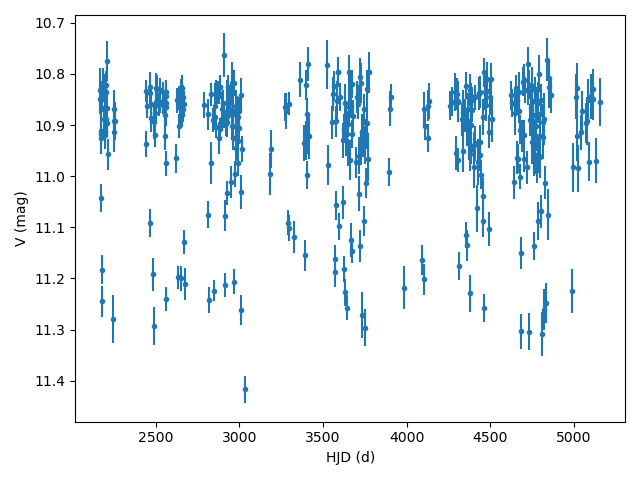

In [90]:
from astropy.table import Table

data = Table.read("example_asas_lc.dat",format='ascii')

t,y,y_unc = ( data['hjd'], data['mag'], data['mag_unc'])


fig, ax = plt.subplots()
ax.errorbar(t, y, y_unc, fmt='.')
ax.set_xlabel('HJD (d)')
ax.set_ylabel('V (mag)')
ax.set_ylim(ax.get_ylim()[::-1])
fig.tight_layout()

**Problem 2b**

Use `LombScargle` to measure the periodogram. Then plot the periodogram and the phase folded light curve at the best-fit period.

*Hint* - search periods longer than 2 hr. 

MH: this means maximum_frequency = 12

<IPython.core.display.Javascript object>


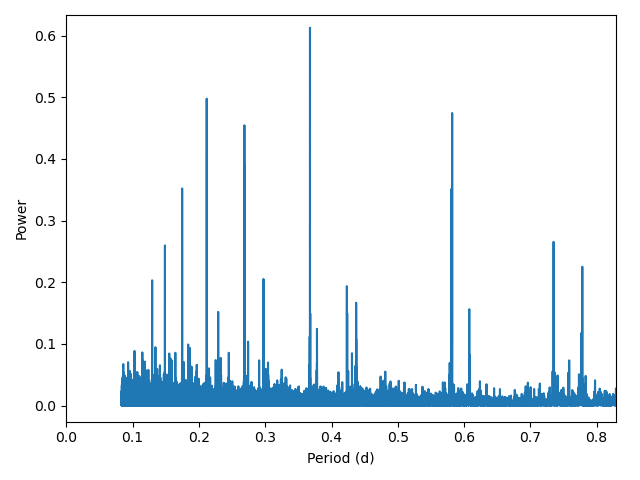

In [138]:
ls = LombScargle( t,y,y_unc)
frequency, power = ls.autopower(maximum_frequency = 12)

fig,ax = plt.subplots()
ax.plot(1/frequency,power)
ax.set_ylabel("Power")
ax.set_xlabel("Period (d)")
ax.set_xlim(0, 10)

#axins = plt.axes([.25, .55, .6, .3])
#axins.plot( # complete
#axins.set_xlim(0,5)
fig.tight_layout()

0.3675383199419227


<IPython.core.display.Javascript object>


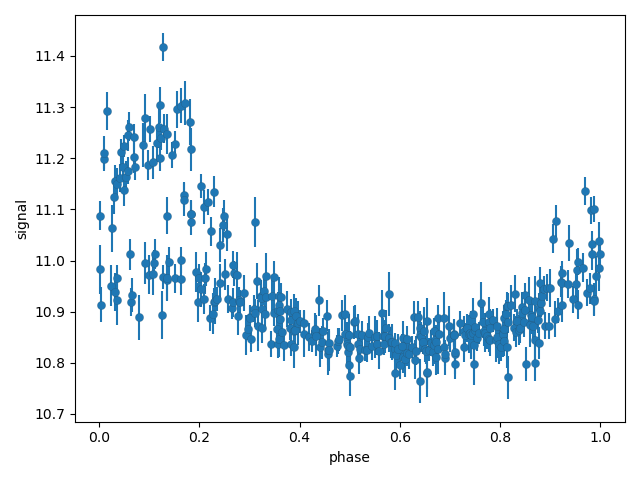

In [139]:
# plot the phase folded light curve

#period = 1/frequency[np.logical_and(3.6<1/frequency,1/frequency<3.7)][np.argsort(power[np.logical_and(3.6<1/frequency,1/frequency<3.7)])[-1]]
period = 1/frequency[np.argmax(power)]
print(period)

phase_plot(t,y,period,y_unc)

**Problem 2c**

Now plot the light curve folded at twice the best LS period.

Which of these 2 is better? 

<IPython.core.display.Javascript object>


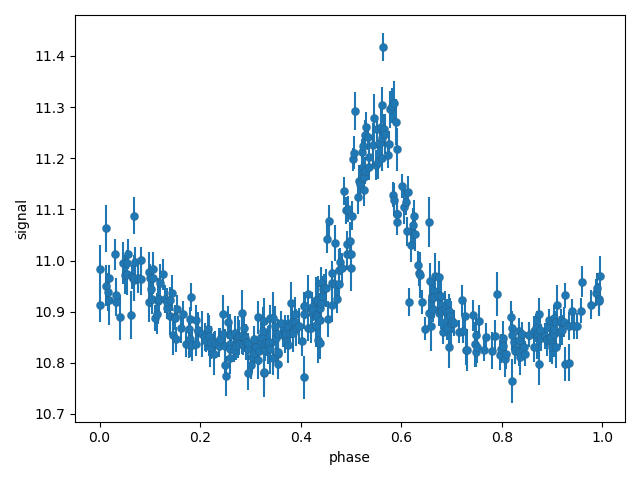

In [140]:
phase_plot(t,y,2*period,y_unc)

Herein lies a fundamental issue regarding the LS periodogram: the model does not search for "periodicity." The LS model asks if the data support a sinusoidal signal. As astronomers we typically assume this question is good enough, but as we can see in the example of this eclipsing binary that is not the case [and this is not limited to eclipsing binaries]. 

We can see why LS is not sufficient for an EB by comparing the model to the phase-folded light curve:

**Problem 2d**

Overplot the model on top of the phase folded light curve. 

*Hint* – you can access the best LS fit via the [`.model()`](https://docs.astropy.org/en/stable/timeseries/lombscargle.html#the-lomb-scargle-model) method on `LombScargle` objects in astropy.

<IPython.core.display.Javascript object>


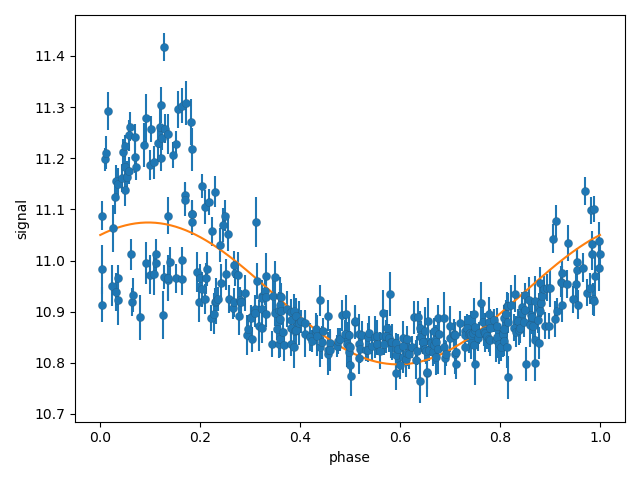

In [142]:
phase_plot( t,y,period,y_unc)

phase_grid = np.linspace(0,1,200)
plt.plot( phase_grid, ls.model(phase_grid*period, 1/period)) # Adam does this line like this too


One way to combat this very specific issue is to include more Fourier terms at the harmonic of the best fit period. This is easy to implement in `LombScargle` with the `nterms` keyword. [Though always be weary of adding degrees of freedom to a model, especially at the large pipeline level of analysis.]

**Problem 2e**

Calculate the LS periodogram for the eclipsing binary, with `nterms` = 1, 2, 3, 4, 5. Report the best-fit period for each of these models.

*Hint* - we have good reason to believe that the best fit frequency is < 3 in this case, so set `maximum_frequency = 3`.

<IPython.core.display.Javascript object>


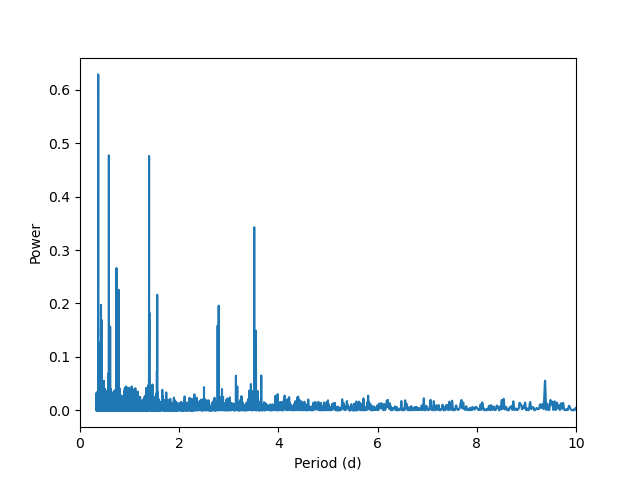

<IPython.core.display.Javascript object>


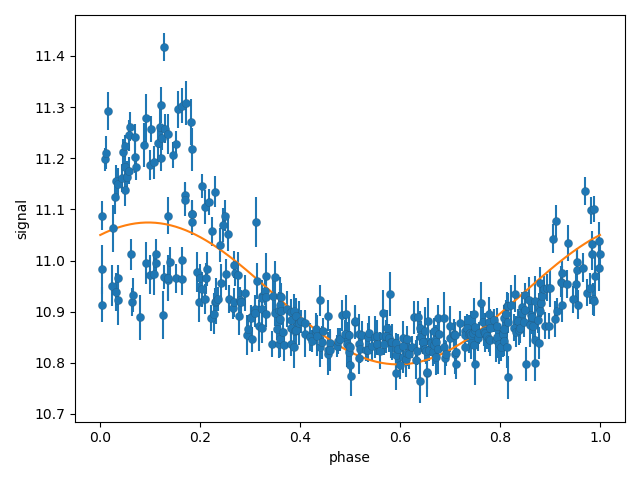

For 1 harmonics, P_LS = 0.36753832


<IPython.core.display.Javascript object>


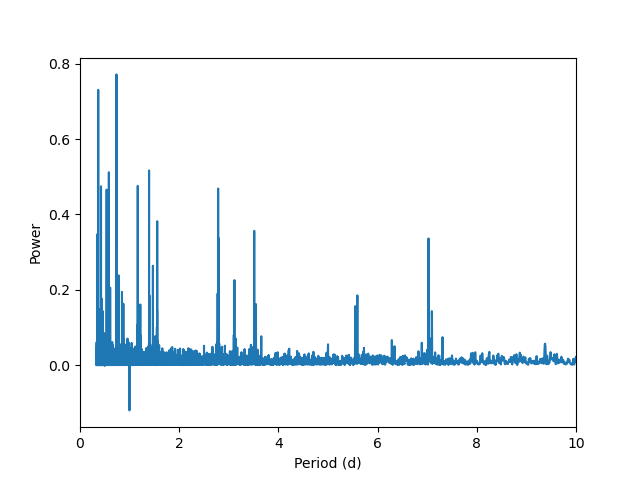

<IPython.core.display.Javascript object>


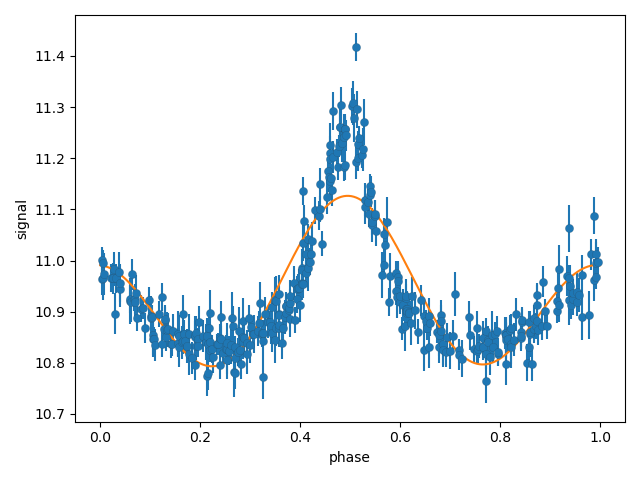

For 2 harmonics, P_LS = 0.73508568


<IPython.core.display.Javascript object>


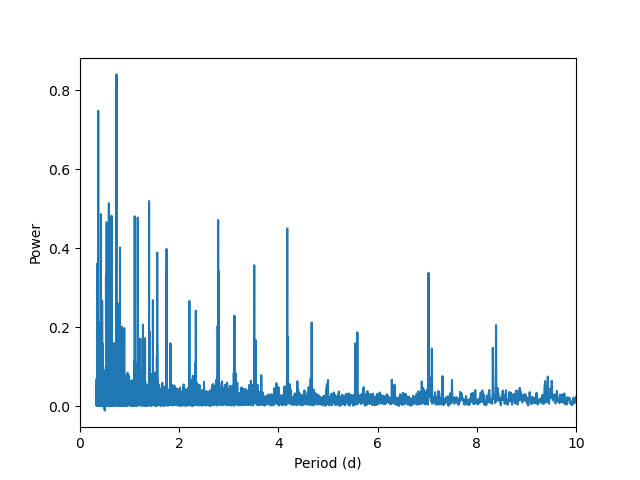

<IPython.core.display.Javascript object>


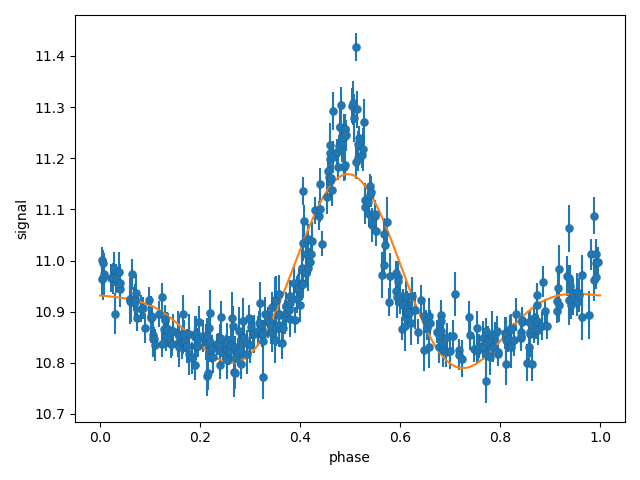

For 3 harmonics, P_LS = 0.73508568


<IPython.core.display.Javascript object>


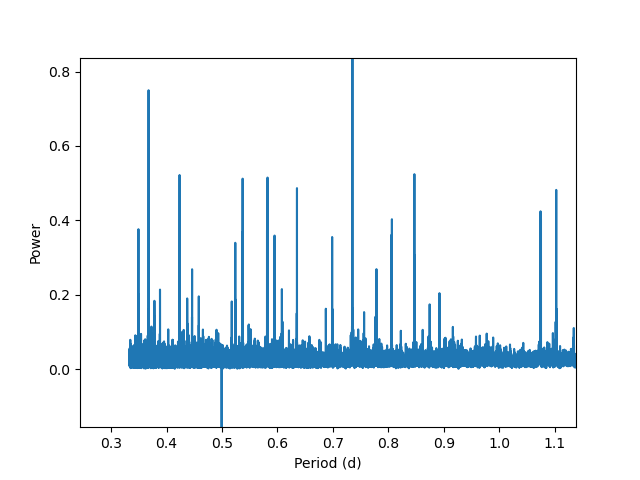

<IPython.core.display.Javascript object>


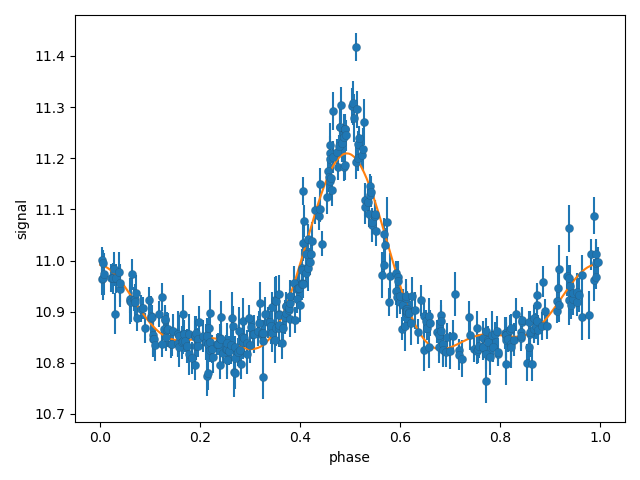

For 4 harmonics, P_LS = 0.73508568


C:\Users\matth\AppData\Local\Temp/ipykernel_1768/3311916874.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


<IPython.core.display.Javascript object>


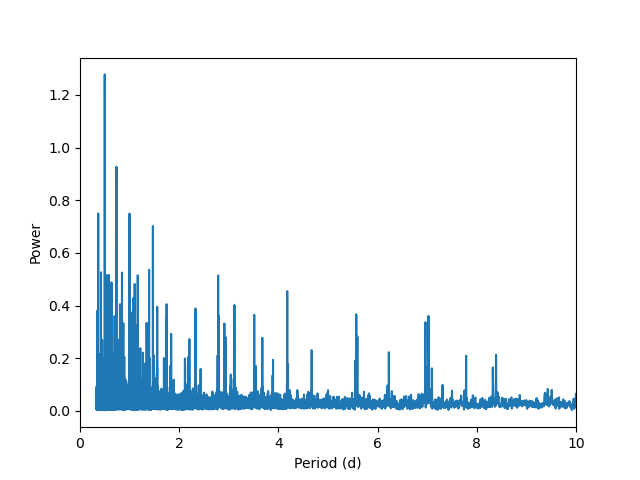

<IPython.core.display.Javascript object>


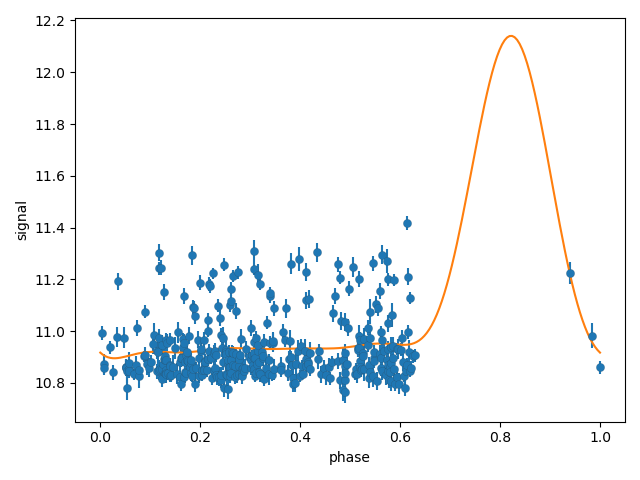

For 5 harmonics, P_LS = 0.49864292


In [136]:

for i in np.arange(1,6):
    ls = LombScargle( t,y,y_unc, nterms = i)
    frequency, power = ls.autopower(maximum_frequency = 3)
    
    fig,ax = plt.subplots()
    ax.plot(1/frequency,power)
    ax.set_ylabel("Power")
    ax.set_xlabel("Period (d)")
    ax.set_xlim(0, 1)
    
    period = 1/frequency[np.argmax(power)]
    
    phase_plot( t,y,period,y_unc)

    phase_grid = np.linspace(0,1,200)
    plt.plot( phase_grid, ls.model(phase_grid*period, 1/period))
    plt.tight_layout()
    
    
    print('For {:d} harmonics, P_LS = {:.8f}'.format(i,period))

Interestingly, for the $n=2, 3, 4$ harmonics, it appears as though we get the period that we have visually confirmed. However, by $n=5$ harmonics we no longer get a reasonable answer. Again - be very careful about adding harmonics, especially in large analysis pipelines.


MH: Autopower() stuggles with getting a low enough period, so set max frequency so what you think is needed. nterms>1 means instead of calculating periodogram by calculating chi2 for a single sinusoid at each frequency, you calculate chi2 for a model with n harmonics at frequencies f,2f,3f,... This means that a periodic but non-sinusoidal signal will be correctly fitted and have period extracted by LS.

**Problem 2f**

Plot the the $n = 4$ model on top of the light curve folded at the correct period.

<IPython.core.display.Javascript object>


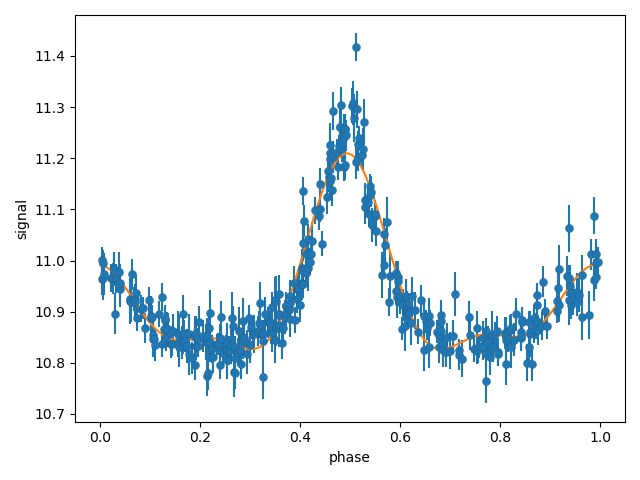

In [147]:
ls = LombScargle( t,y,y_unc, nterms = 4)
frequency, power = ls.autopower(maximum_frequency = 3)

period = 1/frequency[np.argmax(power)]

phase_plot( t,y,period,y_unc)

phase_grid = np.linspace(0,1,1000)
plt.plot(phase_grid, ls.model(phase_grid*period, 1/period))
plt.tight_layout()

This example also shows why it is somewhat strange to provide an uncertainty with a LS best-fit period. Errors tend to be catastrophic, and not some small fractional percentage, with the LS periodogram.

In the case of the above EB, the "best-fit" period was off by a factor 2. This is not isolated to EBs, however, LS periodograms frequently identify a correct harmonic of the true period, but not the actual period of variability. 

## Problem 3) The "Real" World

**Problem 3a** 

Re-write `gen_periodic_data` to create periodic signals using the first 4 harmonics in a Fourier series. The $n > 1$ harmonics should have random phase offsets, and the amplitude of the $n > 1$ harmonics should be drawn randomly from a uniform distribution between 0 and `amplitude` the amplitude of the first harmonic.

In [155]:
def gen_periodic_data(x, period=1, amplitude=1, phase=0, noise=0):
    '''Generate periodic data
    
    Parameters
    ----------
    x : array-like
        input values to evaluate the array
    
    period : float (default=1)
        period of the periodic signal
    
    amplitude : float (default=1)
        amplitude of the periodic signal
    
    phase : float (default=0)
        phase offset of the periodic signal
    
    noise : float (default=0)
        variance of the noise term added to the periodic signal
    
    Returns
    -------
    y : array-like
        Periodic signal evaluated at all points x
    '''
    
    y1 = amplitude*np.sin(2*np.pi*x/(period) - phase)
    amp2 = np.random.uniform(0,amplitude)
    phase2 = np.random.uniform(0,2*np.pi)
    y2 = amp2*np.sin(2*2*np.pi*x/(period) - phase2)
    amp3 = np.random.uniform(0,amplitude)
    phase3 = np.random.uniform(0,2*np.pi)
    y3 = amp3*np.sin(3*2*np.pi*x/(period) - phase3)
    amp4 = np.random.uniform(0,amplitude)
    phase4 = np.random.uniform(0,2*np.pi)
    y4 = amp3*np.sin(4*2*np.pi*x/(period) - phase3)
    dy = np.random.normal(0, np.sqrt(noise), size=len(x))
    return y1 + y2 + y3 + y4 + dy

**Problem 3b**

Confirm the updated version of `gen_periodic_data` works by creating a phase plot for a simulated signal with `amplitude = 4`, `period = 1.234`, and `noise=0.81`, and 100 observations obtained on a regular grid from 0 to 50.

<IPython.core.display.Javascript object>


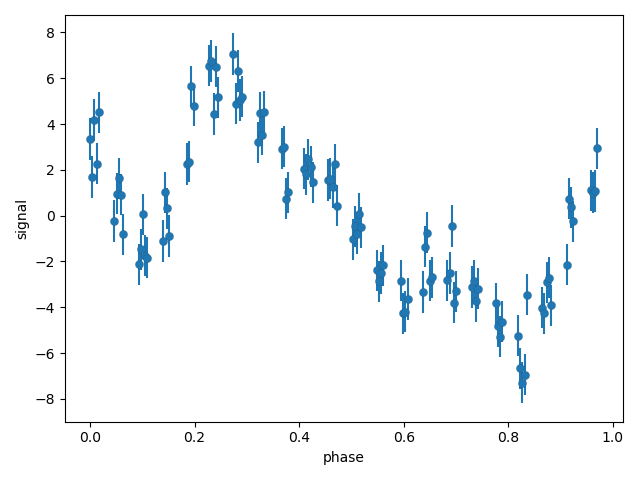

In [159]:
np.random.seed(185)
x_grid = np.linspace(0,50,100)
y = gen_periodic_data(x_grid,1.234,4,noise=0.81)

phase_plot(x_grid,y,1.234,np.sqrt(0.81))

**Problem 3c** 

Simulate 1000 "realistic" light curves using the astronomical cadence from **1d** for a full survey duration of 2 years. 

For each light curve draw the period randomly from [0.2, 10], and the amplitude randomly from [1, 5], and the noise randomly from [1,2].

Record the period in an array `true_p` and estimate the period for the simulated data via LS and store the result in an array `ls_p`.

In [ ]:
n_lc = 1000
true_p = np.zeros(n_lc)
ls_p = np.zeros_like(true_p)
np.random.seed(185)

for lc in range(n_lc):
    # set up simulated observations
    t_obs = np.arange(0, 2*365, 3)      # 3d cadence
    A = np.random.uniform(1,5)
    true_p[lc] = np.random.uniform(0.2,10)
    noise = np.random.uniform(1,2)
    y = gen_periodic_data(t_obs, true_p[lc], A, noise)
    ls = LombScargle( t_obs,y,np.sqrt(noise), nterms=1)
    #nterms=1 as in real data we don't know if harmonics are present
    frequency,power = ls.autopower(maximum_frequency=25) # actual max is 20

    ls_p[lc] = 1/frequency[np.argmax(power)]
    print(ls_p[lc])
    
    fig,ax = plt.subplots()
    ax.plot(1/frequency,power)
    ax.set_ylabel("Power")
    ax.set_xlabel("Period (d)")
    ax.set_xlim(0, 50)
    
    phase_plot( t_obs,y,ls_p[lc],y_unc)

    phase_grid = np.linspace(0,1,200)
    plt.plot( phase_grid, ls.model(phase_grid*period, 1/period))
    plt.tight_layout()
    

**Problem 3d**

Plot the LS recovered period vs. the true period for the simulated sources. 

Do you notice anything interesting? Do you manage to recover the correct period most of the time?

In [ ]:
fig, ax = plt.subplots()
ax.plot( # complete
ax.set_ylim(0, 20)
ax.set_xlabel('True period (d)')
ax.set_ylabel('LS peak (d)')
fig.tight_layout()

**Problem 3e**

For how many of the simulated sources do you recover the correct period? Consider a period estimate "correct" if the LS estimate is within 10% of the true period.

In [ ]:
# complete

The results are a bit disappointing. However, it is also clear that there is strong structure in the plot off the 1:1 line. That structure can be understood in terms of the window function that was discussed in **1d**, **1e**, and **1f**.

**Problem 3f**

Recreate the plot in **3d** and overplot the line

$$P_\mathrm{LS} = \left(\frac{1}{P_\mathrm{true}} + \frac{n}{3}\right)^{-1}$$

for $n = -2, -1, 1, 2$.

*Hint* - only plot the values where $P_\mathrm{LS} > 0$ since, by definition, we do not search for negative periods.

In [ ]:
p_grid = np.linspace(1e-1,10,100)

fig, ax = plt.subplots()
ax.plot(# complete
    # complete
    # complete
    # complete
    
ax.set_ylim(0, 9)
ax.set_xlabel('True period (d)')
ax.set_ylabel('LS peak (d)')
fig.tight_layout()

What in the...

We see that these lines account for a lot of the off-diagonal structure in this plot.

In this case, what is happening is that the true frequency of the signal $f_\mathrm{true}$ is being aliased by the window function and it's harmonics. In other words LS is pulling out $f_\mathrm{true} + n\delta{f}$, where $n$ is an integer and $\delta{f}$ is the observational cadence $3\,\mathrm{d}$. Many of the false positives can be explained via the window function.

Similarly, LS might be recovering higher order harmonics of the true period since we aren't trying to recover pure sinusoidal signals in this simulation. These harmonics would also be aliased by the window function, so LS will pull out $f_\mathrm{true}/m + n\delta{f}$, where $m$ is a postive integer.

**Problem 3g**

Recreate the plot in **3d** and overplot lines for the $m = 2$ harmonic aliased with $n = -1, 1, 2$.

*Hint* - only plot the values where $P_\mathrm{LS} > 0$ since, by definition, we do not search for negative periods.

In [ ]:
p_grid = np.linspace(1e-1,10,100)

fig, ax = plt.subplots()
ax.plot(# complete
    # complete
    # complete
    # complete

ax.set_ylim(0, 2)
ax.set_xlabel('True period (d)')
ax.set_ylabel('LS peak (d)')
fig.tight_layout()

The last bit of structure can be understood via the symmetry in the LS periodogram about 0. In particular, if there is an aliased frequency that is less than 0, which will occur for $n < 0$ in the equations above, then there will also be power at the positive value of that frequency. In other words, LS will pull out $|f_\mathrm{true}/m + n\delta{f}|$.

**Problem 3h**

Recreate the plot in **3d** and overplot lines for the "reflected" $m = 1$ harmonic aliased with $n = -3, -2, -1$.

*Hint* - only plot the values where $P_\mathrm{LS} < 0$ since we are looking for "reflected" peaks in the periodogram in this case. 

In [ ]:
p_grid = np.linspace(1e-1,10,1000)

fig, ax = plt.subplots()
ax.plot(# complete
    # complete
    # complete
    # complete

ax.set_ylim(0, 15)
ax.set_xlabel('True period (d)')
ax.set_ylabel('LS peak (d)')
fig.tight_layout()

Now we have seen that nearly all the structure in the LS period vs. true period plot can be explained via aliasing with the window function! This is good (we understand why the results do not conform to what we expect), but also bad, (we were not able to recover the correct period for the majority of our sources). Ultimately, this means - be careful when inspecting the results of the LS periodogram as the peaks aren't driven solely by the signal from the source in question!

(If only there were some way to get rid of the sun, then we'd never have these problems...)

## Conclusions

The Lomb-Scargle periodogram is a useful tool to search for *sinusoidal* signals in noisy, irregular data. 

However, as highlighted throughout, there are many ways in which the methodology can run awry.

In closing, I will summarize some practical considerations from VanderPlas (2017): 

  1. Choose an appropriate frequency grid (defaults in `LombScargle` are not sufficient)
  2. Calculate the LS periodogram for the observation times to search for dominant signals (e.g., 1 day in astro)
  3. Compute LS periodogram for data (avoid multi-Fourier models if signal unknown)
  4. Plot periodogram and various FAP levels (do not over-interpret FAP)
  5. If window function shows strong aliasing, plot phased light curve at each peak (now add more Fourier terms if necessary)
  6. If looking for a particular signal (e.g., detatched EBs), consider different methods that better match expected signal
  7. Inject fake signals into data to understand systematics if using LS in a survey pipeline

### Finally, Finally

As a very last note: know that there are many different ways to search for periodicity in astronomical data. Depending on your application (and computational resources), LS may be a poor choice (even though this is often the default choice by all astronomers!) [Graham et al. (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G) provides a summary of several methods using actual astronomical data. The results of that study show that no single method is best. However, they also show that no single method performs particularly well: the detection efficiences in Graham et al. (2013) are disappointing given the importance of periodicity in astronomical signals.

Period detection is a fundamental problem for astronomical time-series, but it is especially difficult in "production" mode. Be careful when setting up pipelines to analyze large datasets.  

**Challenge Problem**

Re-create problem 4, but include additional terms in the fit with the LS periodogram. What differences do you notice when comparing the true period to the best-fit LS periods?

## Helper Functions

We developed useful helper functions as part of [Lecture III](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Session13/Day3/IntroductionToTheLombScarglePeriodogram.ipynb) from this session. 

These functions generate periodic data, and phase fold light curves on a specified period. These functions will once again prove useful, so we include them here in order to simulate data above. 

**Helper 1**

Create a function, `gen_periodic_data`, that creates simulated data (including noise) over a grid of user supplied positions:

$$ y = A\,cos\left(\frac{x}{P} - \phi\right) + \sigma_y$$

where $A, P, \phi$ are inputs to the function. `gen_periodic_data` should include Gaussian noise, $\sigma_y$, for each output $y_i$.

In [76]:
def gen_periodic_data(x, period=1, amplitude=1, phase=0, noise=0):
    '''Generate periodic data given the function inputs
    
    y = A*cos(x/p - phase) + noise
    
    Parameters
    ----------
    x : array-like
        input values to evaluate the array
    
    period : float (default=1)
        period of the periodic signal
    
    amplitude : float (default=1)
        amplitude of the periodic signal
    
    phase : float (default=0)
        phase offset of the periodic signal
    
    noise : float (default=0)
        variance of the noise term added to the periodic signal
    
    Returns
    -------
    y : array-like
        Periodic signal evaluated at all points x
    '''
    
    y = amplitude*np.sin(2*np.pi*x/(period) - phase) + np.random.normal(0, np.sqrt(noise), size=len(x))
    return y

**Helper 2**

Create a function, `phase_plot`, that takes x, y, and $P$ as inputs to create a phase-folded light curve (i.e., plot the data at their respective phase values given the period $P$).

Include an optional argument, `y_unc`, to include uncertainties on the `y` values, when available.

In [77]:
def phase_plot(x, y, period, y_unc = 0.0, mag_plot=False):
    '''Create phase-folded plot of input data x, y
    
    Parameters
    ----------
    x : array-like
        data values along abscissa

    y : array-like
        data values along ordinate

    period : float
        period to fold the data
        
    y_unc : array-like
        uncertainty of the 
    '''    
    phases = (x/period) % 1
    if isinstance(y_unc, (np.floating, float)):
        y_unc = np.ones_like(x)*y_unc

    plot_order = np.argsort(phases)
    fig, ax = plt.subplots()
    ax.errorbar(phases[plot_order], y[plot_order], y_unc[plot_order],
                 fmt='o', mec="0.2", mew=0.1)
    ax.set_xlabel("phase")
    ax.set_ylabel("signal")
    if mag_plot:
        ax.set_ylim(ax.get_ylim()[::-1])
    fig.tight_layout()